In [1]:
import dataclasses
import os
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import pickle
import wandb
import warnings

from datetime import datetime
from sklearn.model_selection import KFold
from fastprogress import progress_bar

from fos import seminmf_full as seminmf

warnings.filterwarnings("ignore")

/home/users/swl1/.local/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
WANDB_PROJECT = "serotonin-fos-seminmf-bootstrap"
# RESULTS_DIR = os.path.join("..", "results", datetime.now().strftime("%Y_%m_%d-%H_%M") + "-bootstrap")
RESULTS_DIR = r"/home/groups/swl1/swl1/fos/results/2024_05_30-21_19-bootstrap"

if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

## Combine all the per-mouse arrays into one file

In [3]:
# DATA_DIREC = "/scratch/groups/swl1/serotonin/npz_4"

# N = len(os.listdir(DATA_DIREC))
# height = 89
# width = 95
# depth = 80
# intensity_3d = np.zeros((N, height, width, depth), dtype=np.float32)
# counts_3d = np.zeros((N, height, width, depth), dtype=np.int16)
# inds = -1 * np.ones(N)

# for i, fname in enumerate(os.listdir(DATA_DIREC)):
#     # print(fname)
#     ind = int(fname[:3])
#     inds[i] = ind

#     npz = np.load(os.path.join(DATA_DIREC, fname))
#     coords = npz["coords"]
#     x, y, z = coords.T
#     intensity_3d[i][x, y, z] = npz["log_vs"]
#     counts_3d[i][x, y, z] = npz["Ns"]
    
# np.savez(os.path.join(DATA_DIREC, f"downsampled_data_4.npz"),
#          intensity=intensity_3d, counts=counts_3d, mouse_inds=inds)

## Load the combined data

Note: files are permanently available on [Google Drive](https://drive.google.com/drive/u/0/folders/1xD54Uq4cKJsACmy8KVZZZ5YGCjF6ZrkC). The scratch storage may be deleted periodically by Sherlock.

In [4]:
!ls -lh /scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz

-rw-r-----+ 1 swl1 swl1 655M May 30 09:55 /scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz


In [5]:
DATA_FILE = "/scratch/groups/swl1/serotonin/npz_4/downsampled_data_4.npz"
data = np.load(DATA_FILE)
intensity_3d = data["intensity"][:-1]
counts_3d = data["counts"][:-1]
mouse_inds = data["mouse_inds"]
num_mice = counts_3d.shape[0]
assert num_mice == 168
assert intensity_3d.shape[0] == 168

In [6]:
DRUG_FILE = "/scratch/groups/swl1/serotonin/drug_ids.npy"
drugs = np.load(DRUG_FILE)

### Remove the left edge to address edge effects

In [7]:
LEFT_TRUNC = 8
counts_3d = counts_3d[:, LEFT_TRUNC:, :, :]
intensity_3d = intensity_3d[:, LEFT_TRUNC:, :, :]
counts_3d.shape

(168, 81, 95, 80)

### Only work with live voxels

In [8]:
alive_voxels = jnp.sum(counts_3d, axis=0) > 0
num_alive_voxels = alive_voxels.sum()
print(alive_voxels.sum(), "/", np.prod(intensity_3d.shape[1:]), "voxels are 'alive'")

348766 / 615600 voxels are 'alive'


In [9]:
intensity = intensity_3d[:, alive_voxels]
counts = counts_3d[:, alive_voxels]
intensity[counts == 0] = 0.0

(<Axes: >, <matplotlib.image.AxesImage at 0x7f555d8306d0>)

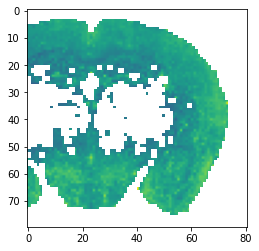

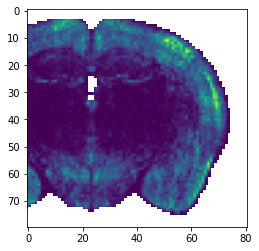

In [10]:
def plot_coronal(flat_array, y_idx, ax=None):
    arr = jnp.nan * jnp.zeros(alive_voxels.shape)
    arr = arr.at[alive_voxels].set(flat_array)

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    im = ax.imshow(arr[:, y_idx, :].T)
    return ax, im

vis_intensity = jnp.where(counts == 0, jnp.nan, intensity)

plot_coronal(vis_intensity[100], 50)

plot_coronal(counts[100], 50)

## Fit the model to many bootstrap replicates

In [ ]:
num_bootsrap = 1000
sparsity_penalty = 0.01
num_factors = 14
mean_func = "softplus"
elastic_net_frac = 1.0
num_iters = 500
num_coord_ascent_iters = 1

# Run bootstrap 
for i in progress_bar(range(num_bootsrap)):
    print(f"bootstrap sample {i}")
    result_file = os.path.join(RESULTS_DIR, f"params_{i:04d}.pkl")
    if os.path.exists(result_file):
        continue
        
    # Create a bootstrapped dataset
    key = jr.PRNGKey(i)
    bootstrap_inds = jr.choice(key, num_mice, shape=(num_mice,), replace=True)
    bootstrap_counts = counts[bootstrap_inds]
    bootstrap_intensity = intensity[bootstrap_inds]
    
    # Some voxels may be empty now, unfortunately...
    bootstrap_alive_voxels = bootstrap_counts.sum(axis=0) > 0
    bootstrap_counts = bootstrap_counts[:, bootstrap_alive_voxels]
    bootstrap_intensity = bootstrap_intensity[:, bootstrap_alive_voxels]
    
    # Initialize wandb run
    run = wandb.init(
        project=WANDB_PROJECT,
        job_type="train",
        config=dict(
            bootstrap_iter=i,
            bootstrap_inds=bootstrap_inds,
            sparsity_penalty=sparsity_penalty,
            num_factors=num_factors,
            elastic_net_frac=elastic_net_frac,
            max_num_iters=num_iters,
            num_coord_ascent_iters=num_coord_ascent_iters,
            mean_func=mean_func,
            initialization="nnsvd",
            data_file=DATA_FILE,
            drug_file=DRUG_FILE,
            left_trunc=LEFT_TRUNC)
        )
    
    
    # Initialize the seminmf model
    initial_params = seminmf.initialize_nnsvd(bootstrap_counts, 
                                              bootstrap_intensity, 
                                              num_factors, 
                                              mean_func, 
                                              drugs=None)
    
    print("fitting model")
    params, losses, heldout_loglikes = \
        seminmf.fit_poisson_seminmf(bootstrap_counts,
                                    bootstrap_intensity,
                                    initial_params,
                                    mask=None,
                                    mean_func=mean_func,
                                    sparsity_penalty=sparsity_penalty,
                                    elastic_net_frac=elastic_net_frac,
                                    num_iters=num_iters,
                                    num_coord_ascent_iters=num_coord_ascent_iters,
                                    tolerance=1e-5
                                    )
    
    wandb.run.summary["final_loss"] = losses[-1]
    wandb.run.summary["heldout_loglike"] = heldout_loglikes[-1]

    # Extract the full factors
    factors = jnp.zeros((num_factors, num_alive_voxels))
    factors = factors.at[:, bootstrap_alive_voxels].set(params.factors)

    # Save the results for this bootstrap
    print("saving results")
    with open(result_file, 'wb') as f:
        pickle.dump(dict(bootstrap_inds=bootstrap_inds,
                         factors=factors,
                         count_loadings=params.count_loadings, 
                         intensity_loadings=params.intensity_loadings,
                        ), 
                    f)

    artifact = wandb.Artifact(name="params_pkl", type="model")
    artifact.add_file(local_path=result_file)
    run.log_artifact(artifact)

    # Log results to wandb
    wandb.finish()


bootstrap sample 0
bootstrap sample 1
bootstrap sample 2
bootstrap sample 3
bootstrap sample 4
bootstrap sample 5
bootstrap sample 6
bootstrap sample 7
bootstrap sample 8
bootstrap sample 9
bootstrap sample 10
bootstrap sample 11
bootstrap sample 12
bootstrap sample 13
bootstrap sample 14
bootstrap sample 15
bootstrap sample 16
bootstrap sample 17
bootstrap sample 18
bootstrap sample 19
bootstrap sample 20
bootstrap sample 21
bootstrap sample 22
bootstrap sample 23
bootstrap sample 24
bootstrap sample 25
bootstrap sample 26
bootstrap sample 27
bootstrap sample 28
bootstrap sample 29
bootstrap sample 30
bootstrap sample 31
bootstrap sample 32
bootstrap sample 33
bootstrap sample 34
bootstrap sample 35
bootstrap sample 36
bootstrap sample 37
bootstrap sample 38
bootstrap sample 39
bootstrap sample 40
bootstrap sample 41
bootstrap sample 42
bootstrap sample 43
bootstrap sample 44
bootstrap sample 45
bootstrap sample 46
bootstrap sample 47
bootstrap sample 48
bootstrap sample 49
bootstrap 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/users/swl1/.local/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: scott-linderman (linderman-lab). Use `wandb login --relogin` to force relogin


fitting model


saving results


final_loss,4.16607
heldout_loglike,0.0


bootstrap sample 160


fitting model


saving results


final_loss,4.11332
heldout_loglike,0.0


bootstrap sample 161


fitting model


saving results


final_loss,4.1868
heldout_loglike,0.0


bootstrap sample 162


fitting model


saving results


final_loss,4.13832
heldout_loglike,0.0


bootstrap sample 163


fitting model


saving results


final_loss,4.17062
heldout_loglike,0.0


bootstrap sample 164


fitting model


saving results


final_loss,4.17382
heldout_loglike,0.0


bootstrap sample 165


fitting model


2024-06-14 10:42:18.878091: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.3407 = f32[] reduce(f32[168,347876]{1,0} %broadcast.120, f32[] %constant.15), dimensions={0,1}, to_apply=%region_95.3403, metadata={op_name="jit(_step)/jit(main)/reduce_sum[axes=(0, 1)]" source_file="/home/groups/swl1/swl1/fos/fos/seminmf_full.py" source_line=97}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-14 10:42:18.892744: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.014790763s
Constant folding an instruction is taking > 1s:

  %reduce.3407 = f32[] reduc

saving results


final_loss,4.14569
heldout_loglike,0.0


bootstrap sample 166


fitting model


saving results


final_loss,4.13921
heldout_loglike,0.0


bootstrap sample 167


fitting model


saving results


final_loss,4.11377
heldout_loglike,0.0


bootstrap sample 168


fitting model


saving results


final_loss,4.18982
heldout_loglike,0.0


bootstrap sample 169


fitting model


saving results


final_loss,4.16955
heldout_loglike,0.0


bootstrap sample 170


fitting model


saving results


final_loss,4.19983
heldout_loglike,0.0


bootstrap sample 171


fitting model


saving results


final_loss,4.17331
heldout_loglike,0.0


bootstrap sample 172


fitting model


saving results


final_loss,4.13203
heldout_loglike,0.0


bootstrap sample 173


fitting model


saving results


final_loss,4.21706
heldout_loglike,0.0


bootstrap sample 174


fitting model


saving results


final_loss,4.14484
heldout_loglike,0.0


bootstrap sample 175


fitting model


saving results


final_loss,4.15152
heldout_loglike,0.0


bootstrap sample 176


fitting model


saving results


final_loss,4.15795
heldout_loglike,0.0


bootstrap sample 177


fitting model


saving results


final_loss,4.22863
heldout_loglike,0.0


bootstrap sample 178


fitting model


saving results


final_loss,4.1585
heldout_loglike,0.0


bootstrap sample 179


fitting model


saving results


final_loss,4.1606
heldout_loglike,0.0


bootstrap sample 180


fitting model


saving results


final_loss,4.14495
heldout_loglike,0.0


bootstrap sample 181


fitting model


saving results


final_loss,4.16862
heldout_loglike,0.0


bootstrap sample 182


fitting model


saving results


final_loss,4.18647
heldout_loglike,0.0


bootstrap sample 183


fitting model


saving results


final_loss,4.14566
heldout_loglike,0.0


bootstrap sample 184


fitting model


saving results


final_loss,4.17499
heldout_loglike,0.0


bootstrap sample 185


fitting model


saving results


final_loss,4.13212
heldout_loglike,0.0


bootstrap sample 186


fitting model


saving results


final_loss,4.13071
heldout_loglike,0.0


bootstrap sample 187


fitting model


saving results


final_loss,4.13947
heldout_loglike,0.0


bootstrap sample 188


fitting model


saving results


final_loss,4.15773
heldout_loglike,0.0


bootstrap sample 189


fitting model


saving results


final_loss,4.13289
heldout_loglike,0.0


bootstrap sample 190


fitting model


saving results


final_loss,4.14766
heldout_loglike,0.0


bootstrap sample 191


fitting model


saving results


final_loss,4.184
heldout_loglike,0.0


bootstrap sample 192


fitting model


saving results


final_loss,4.16618
heldout_loglike,0.0


bootstrap sample 193


fitting model


saving results


final_loss,4.13478
heldout_loglike,0.0


bootstrap sample 194


fitting model


saving results


final_loss,4.17475
heldout_loglike,0.0


bootstrap sample 195


fitting model


saving results


final_loss,4.14056
heldout_loglike,0.0


bootstrap sample 196


fitting model


saving results


final_loss,4.13939
heldout_loglike,0.0


bootstrap sample 197


fitting model


saving results


final_loss,4.16538
heldout_loglike,0.0


bootstrap sample 198


fitting model


saving results


final_loss,4.19173
heldout_loglike,0.0


bootstrap sample 199


fitting model


saving results


final_loss,4.14947
heldout_loglike,0.0


bootstrap sample 200


fitting model


saving results


final_loss,4.09335
heldout_loglike,0.0


bootstrap sample 201


fitting model


saving results


final_loss,4.16484
heldout_loglike,0.0


bootstrap sample 202


fitting model


saving results


final_loss,4.13703
heldout_loglike,0.0


bootstrap sample 203


fitting model


saving results


final_loss,4.17047
heldout_loglike,0.0


bootstrap sample 204


fitting model


saving results


final_loss,4.17158
heldout_loglike,0.0


bootstrap sample 205


fitting model


saving results


final_loss,4.1934
heldout_loglike,0.0


bootstrap sample 206


fitting model


saving results


final_loss,4.1793
heldout_loglike,0.0


bootstrap sample 207


fitting model


saving results


final_loss,4.11968
heldout_loglike,0.0


bootstrap sample 208


fitting model


saving results


final_loss,4.15062
heldout_loglike,0.0


bootstrap sample 209


fitting model


saving results


final_loss,4.17246
heldout_loglike,0.0


bootstrap sample 210


fitting model


saving results


final_loss,4.1977
heldout_loglike,0.0


bootstrap sample 211


fitting model


saving results


final_loss,4.13727
heldout_loglike,0.0


bootstrap sample 212


fitting model


saving results


final_loss,4.1825
heldout_loglike,0.0


bootstrap sample 213


fitting model


saving results


final_loss,4.14112
heldout_loglike,0.0


bootstrap sample 214


fitting model


saving results


final_loss,4.15292
heldout_loglike,0.0


bootstrap sample 215


fitting model


saving results


final_loss,4.13059
heldout_loglike,0.0


bootstrap sample 216


fitting model


saving results


final_loss,4.21614
heldout_loglike,0.0


bootstrap sample 217


fitting model


saving results


final_loss,4.14327
heldout_loglike,0.0


bootstrap sample 218


fitting model


saving results


final_loss,4.1378
heldout_loglike,0.0


bootstrap sample 219


fitting model


saving results


final_loss,4.14244
heldout_loglike,0.0


bootstrap sample 220


fitting model


saving results


final_loss,4.18686
heldout_loglike,0.0


bootstrap sample 221


fitting model


saving results


final_loss,4.17698
heldout_loglike,0.0


bootstrap sample 222


fitting model


saving results


final_loss,4.16633
heldout_loglike,0.0


bootstrap sample 223


fitting model


saving results


final_loss,4.1872
heldout_loglike,0.0


bootstrap sample 224


fitting model


saving results


final_loss,4.22047
heldout_loglike,0.0


bootstrap sample 225


fitting model


saving results


final_loss,4.18148
heldout_loglike,0.0


bootstrap sample 226


fitting model


saving results


final_loss,4.1599
heldout_loglike,0.0


bootstrap sample 227


fitting model


saving results


final_loss,4.19535
heldout_loglike,0.0


bootstrap sample 228


fitting model


saving results


final_loss,4.13206
heldout_loglike,0.0


bootstrap sample 229


## Test

In [3]:
%run ../scripts/seminmf-fos-boostrap.py

/home/users/swl1/.local/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


348766 / 615600 voxels are 'alive'


bootstrap sample 0
bootstrap sample 1
bootstrap sample 2
bootstrap sample 3
bootstrap sample 4
bootstrap sample 5
bootstrap sample 6
bootstrap sample 7
bootstrap sample 8
bootstrap sample 9
bootstrap sample 10
bootstrap sample 11
bootstrap sample 12
bootstrap sample 13
bootstrap sample 14
bootstrap sample 15
bootstrap sample 16
bootstrap sample 17
bootstrap sample 18
bootstrap sample 19
bootstrap sample 20
bootstrap sample 21
bootstrap sample 22
bootstrap sample 23
bootstrap sample 24
bootstrap sample 25
bootstrap sample 26
bootstrap sample 27
bootstrap sample 28
bootstrap sample 29
bootstrap sample 30
bootstrap sample 31
bootstrap sample 32
bootstrap sample 33
bootstrap sample 34
bootstrap sample 35
bootstrap sample 36
bootstrap sample 37
bootstrap sample 38
bootstrap sample 39
bootstrap sample 40
bootstrap sample 41
bootstrap sample 42
bootstrap sample 43
bootstrap sample 44
bootstrap sample 45
bootstrap sample 46
bootstrap sample 47
bootstrap sample 48
bootstrap sample 49
bootstrap 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/users/swl1/.local/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 3.2.1'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: scott-linderman (linderman-lab). Use `wandb login --relogin` to force relogin


fitting model


2024-06-14 13:52:28.606311: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.3407 = f32[] reduce(f32[168,347918]{1,0} %broadcast.120, f32[] %constant.15), dimensions={0,1}, to_apply=%region_95.3403, metadata={op_name="jit(_step)/jit(main)/reduce_sum[axes=(0, 1)]" source_file="/home/groups/swl1/swl1/fos/fos/seminmf_full.py" source_line=97}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-14 13:52:28.652209: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.04602897s
Constant folding an instruction is taking > 1s:

  %reduce.3407 = f32[] reduce

saving results


final_loss,4.21363
heldout_loglike,0.0


bootstrap sample 248



Aborted!
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/users/swl1/.local/lib/python3.9/site-packages/click/core.py", line 1068, in main
    raise Abort() from None
click.exceptions.Abort

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2761, in safe_execfile
    py3compat.execfile(
  File "/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/utils/py3compat.py", line 168, in execfile
    exec(compiler(f.read(), fname, 'exec'), glob, loc)
  File "/home/groups/swl1/swl1/fos/scripts/seminmf-fos-boostrap.py", line 154, in <module>
    run_sweep()
  File "/home/users/swl1/.local/lib/python3.9/site-packages/click/core.py", line 1130, in __call__
    return self.main(*args, **kwargs)
  File "/home/users/swl1/.local/lib/python3.9/site-packages/click/core.py", line 1098, in main
    sys.exit(1

TypeError: object of type 'NoneType' has no len()